In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score

pd.options.display.max_columns = 2000
pd.options.display.max_rows = 2000

wSBmodels = {}
dfMaster = pd.DataFrame.empty

runSB = 0.2
runCS = -0.423
degrees = [1,2,3,4,5,6]



In [8]:
def build_dataframe():
    dfSpeed = pd.read_csv("data/MLBSprintSpeeds.csv")
    dfSpeedNames = pd.DataFrame(dfSpeed[["Player","Speed"]])
    dfSpeedNames['nameLast'], dfSpeedNames['nameFirst'] = dfSpeed['Player'].str.split(', ',1).str
    dfSpeedNames['nameLast'] = dfSpeedNames['nameLast'].str.strip()



    dfbatting = pd.read_csv("data/baseballReference2017Batting.csv")
    dfbatting = dfbatting[dfbatting['yearID'] == 2017]
    lgwSB = (np.sum(dfbatting['SB']) * runSB + np.sum(dfbatting['CS'])*runCS) / (np.sum(dfbatting['H'])+np.sum(dfbatting['BB'])+np.sum(dfbatting['HBP'])-np.sum(dfbatting['IBB']))
    dfbatting = dfbatting[['playerID', 'yearID', 'SB', 'CS', 'H', 'BB', 'HBP', 'IBB', 'PA']]

    dfmaster = pd.read_csv("data/LahmanMaster.csv")
    dfmaster = dfmaster[['playerID', 'nameFirst', 'nameLast']]

    dfPlayers = pd.merge(dfmaster, dfbatting, on='playerID')
    dfPlayers['Speed'] = -1
    for i, speedRow in dfSpeedNames.iterrows():
        match = dfPlayers.loc[(dfPlayers['nameFirst'] == speedRow.nameFirst)]
        if not match.empty:
            for j, row2 in match.iterrows():
                if row2.nameLast == speedRow.nameLast:
                    dfPlayers.loc[j,'Speed'] = speedRow['Speed']

    dfPlayers = dfPlayers.drop(dfPlayers[dfPlayers['Speed'] < 0].index)
    dfPlayers['wSB'] = dfPlayers['SB'] * runSB + dfPlayers['CS']*runCS - ((dfPlayers['H']+dfPlayers['BB']+dfPlayers['HBP']-dfPlayers['IBB'])*lgwSB)
    dfPlayers['wSBPA'] = dfPlayers['wSB']/dfPlayers['PA']
    dfPlayers = dfPlayers.sort_values('Speed')
    return dfPlayers

In [9]:
def build_models():
    for deg in degrees:
        wSBmodels[deg] = np.polyfit(dfMaster['Speed'], dfMaster['wSB'], deg)

In [10]:
def predict(speed, params):
    wSB = 0
    indexes = list(range(len(params)-1,-1,-1))
    for power, index in zip(indexes, reversed(indexes)):
        wSB += (speed**power)*params[index]
    return wSB

In [11]:
def get_predictions(deg):
    predictions = []
    for speed in dfMaster['Speed']:
        predictions.append(predict(speed, wSBmodels[deg]))
    return predictions

In [12]:
def wSB_master_plot():
        colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
        ax.scatter(dfMaster['Speed'], dfMaster['wSB'], label="Players")
        for deg in degrees:
            preds = get_predictions(deg)
            R2 = r2_score(dfMaster['wSB'], preds)
            ax.plot(dfMaster['Speed'], preds, label="Degree: {0} R2: {1:0.4f}".format(deg, R2))
        ax.set_xlabel("Speed", fontsize=16)
        ax.set_ylabel("wSB", fontsize=16)
        ax.set_title("Regressions over data", fontsize=20); ax.grid(alpha=0.25)
        ax.legend(loc="upper left", fontsize=8);
        return ax

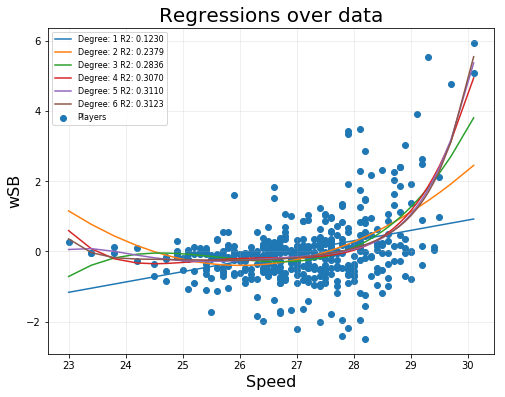

In [13]:
dfMaster = build_dataframe()
build_models()
wSB_master_plot()